In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
!pip install --upgrade pyswarm
from pyswarm import pso

Requirement already up-to-date: pyswarm in /home/vitor/anaconda3/lib/python3.8/site-packages (0.6)


In [ ]:
def f_root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [4]:
def comparison_plot(y_true, y_pred):

    #Simple code to evalutate the prediction of X against y
    eixo_x=np.array(np.arange(0,y_true.size,1))

    fig, ax = plt.subplots(figsize=(16, 5))

    ax.plot(eixo_x, y_true, label='y real')
    ax.plot(eixo_x, y_pred, label='y estimado')
    ax.set_ylabel('Y(i)')
    ax.set_xlabel('i')
    ax.legend()

In [5]:
X=np.load('X.npy')
y=np.load('y.npy')

print("X.shape: {}\ny.shape: {}\n".format(X.shape, y.shape))


X.shape: (506, 13)
y.shape: (506,)



# Grid Search

In [6]:
#Generating grids
C_grid=2**(np.linspace(-5,15,5))
print("C grid is: {}".format(C_grid))

gamma_grid=2**(np.linspace(-15,3,5))
print("Gamma grid is {}".format(gamma_grid))

epsilon_grid=(np.linspace(0.05,1,5))
print("Epsilon grid is {}".format(epsilon_grid))

C grid is: [3.1250e-02 1.0000e+00 3.2000e+01 1.0240e+03 3.2768e+04]
Gamma grid is [3.05175781e-05 6.90533966e-04 1.56250000e-02 3.53553391e-01
 8.00000000e+00]
Epsilon grid is [0.05   0.2875 0.525  0.7625 1.    ]


In [7]:


# Using the Grid Seach
grid_search=GridSearchCV( SVR(kernel='rbf'), 
                          param_grid = { "C"      : C_grid, 
                                         "gamma"  : gamma_grid, 
                                         "epsilon": epsilon_grid}, 
                          scoring = 'neg_root_mean_squared_error')
grid_search.fit(X,y)
#print(grid_search)
                        

GridSearchCV(estimator=SVR(),
             param_grid={'C': array([3.1250e-02, 1.0000e+00, 3.2000e+01, 1.0240e+03, 3.2768e+04]),
                         'epsilon': array([0.05  , 0.2875, 0.525 , 0.7625, 1.    ]),
                         'gamma': array([3.05175781e-05, 6.90533966e-04, 1.56250000e-02, 3.53553391e-01,
       8.00000000e+00])},
             scoring='neg_root_mean_squared_error')

In [8]:
print("Os melhores valores de hiperparâmetros são: {}\nSeu RMSE é: {}".format(grid_search.best_params_, np.absolute(grid_search.best_score_)))

Os melhores valores de hiperparâmetros são: {'C': 32768.0, 'epsilon': 0.05, 'gamma': 3.0517578125e-05}
Seu RMSE é: 3.7825692902690755


Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:



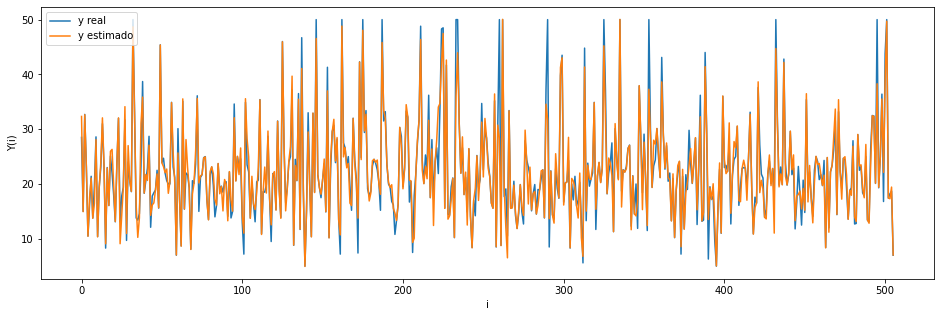

In [9]:
print("Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:\n")
comparison_plot(y,grid_search.best_estimator_.predict(X))


# PSO

In [10]:
#Define the objective function to be optimized. A function that receives the hiper parameters and return the RMES
def pso_objective_function(x):
    
    log_C     = x[0]
    log_gamma = x[1]
    epsilon_  = x[2]


    C_     = 2**log_C
    gamma_ = 2**log_gamma
    
    reg=SVR(kernel  = 'rbf',
            C       = C_,
            gamma   = gamma_,
            epsilon = epsilon_)
    
    neg_root_mean_squared_errors = cross_val_score(reg, X, y, cv=5, scoring = 'neg_root_mean_squared_error')

    # Return the absolute value, since we're seeking to minimize the function value    
    return np.absolute(np.average(neg_root_mean_squared_errors))

In [15]:
# my_pso_objective_function self test! 
# Result should match the grid seach iteration
# For C: 32768.0, 'gamma': 3.0517578125e-05, 'epsilon': 0.05
# The result should be -3.7825692902690755
test_pso_objective_function_val = pso_objective_function([np.log2(32768), np.log2(3.0517578125e-05), 0.05])
print(test_pso_objective_function_val)

3.7825692902690755


In [34]:
# Optimizing the function using PSO:
#                        C,    gamma  epsilon
pso_lower_boundaries = [-5,   -15,   0.05]
pso_upper_boundaries = [15,     3,    1.0]

pso_best_x, pso_best_averaged_rmes = pso(func      = pso_objective_function,
                                         lb        = pso_lower_boundaries, 
                                         ub        = pso_upper_boundaries,
                                         swarmsize = 11,
                                         maxiter   = 11)

print("Os melhores valores de hiperparâmtros são:\nC      : {}\ngamma  : {}\nepsilon: {}\nRMES   : {}".format(2**pso_best_x[0], 2**pso_best_x[1], pso_best_x[2], pso_best_averaged_rmes))



Stopping search: maximum iterations reached --> 11
Os melhores valores de hiperparâmtros são:
C      : 10595.75672531567
gamma  : 3.0517578125e-05
epsilon: 0.8998564984577292
RMES   : 3.8265168254608617


In [36]:
#Quick Test with the values found
test_pso_objective_function_val = pso_objective_function([np.log2(10595.75672531567), np.log2(3.0517578125e-05), 0.8998564984577292])
print(test_pso_objective_function_val)

3.8265168254608617


Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:



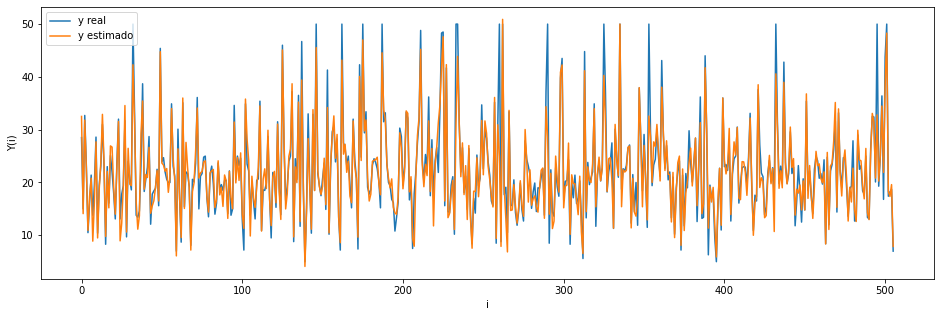

In [39]:
print("Esse é o resultado da aproximação usando os melhores valores de hiperparâmetros:\n")
comparison_plot(y,
SVR(kernel  = 'rbf',
    C       = 2**pso_best_x[0],
    gamma   = 2**pso_best_x[1],
    epsilon = pso_best_x[2]).fit(X,y).predict(X)
    )